First import all the packages needed

In [1]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1.ergast import Ergast
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import warnings
import numpy as np
import scipy.special
import os

Here, all the rounds completed are put into an array so that the data from each can be taken
The names of the races are used - the locations normally - and are then found in the fastf1 package

In [2]:
warnings.filterwarnings('ignore')
os.makedirs('cache_dir', exist_ok=True)
ff1.Cache.enable_cache('cache_dir')

completed_rounds = [
    'Australia', 'China', 'Japan', 'Bahrain', 'Saudi Arabia', 'Miami', 'Emilia-Romagna', 'Monaco', 'Spain', 'Canada', 'Austria', 'Great Britain', 'Belgium', 'Hungary', 'Netherlands','Italy','Azerbaijan','Singapore'
]

Be warned, this next part takes a lot longer to run, here all the data is loaded in

In [3]:
races_2025 = []
for gp in completed_rounds:
    try:
        session = ff1.get_session(2025,gp,'R')
        session.load()
        df_gp = session.results
        df_gp['GrandPrix'] = gp
        races_2025.append(df_gp)
    except Exception as e:
        print(f'Failed to load {gp}: {e}')
df_2025 = pd.concat(races_2025, ignore_index=True)
df_2025['DriverNumber'] = df_2025['DriverNumber'].astype(int)
df_2025['won'] = (df_2025['Position'] == 1).astype(int)

core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', 

In [4]:
driver_stats = df_2025.groupby('DriverNumber').agg({
    'Position' : ['mean', 'min', 'max'],
    'Points' : 'sum',
    'won' : 'sum',
    'GridPosition' : 'mean',
    'TeamName' : 'last',
    'Abbreviation' : 'last'
}).reset_index()

driver_stats.columns = [
    'DriverNumber', 'avg_pos', 'best_pos', 'worst_pos', 'total_points', 'wins', 'avg_grid', 'TeamName', 'Abbreviation'
]

df_train = df_2025.merge(driver_stats, on = 'DriverNumber', how = 'left')
features = [
    'avg_pos', 'best_pos', 'worst_pos', 'total_points', 'wins', 'avg_grid'
]

Now the Machine Learning part actually starts, using RandomForestClassifier and sklearn to build the prediction

In [5]:
X_train = df_train[features]
y_win = df_train['won']
y_position = df_train['Position']

win_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
win_clf.fit(X_train, y_win)

pos_reg = RandomForestRegressor(n_estimators=100, random_state=42)
pos_reg.fit(X_train, y_position)
X_predict = driver_stats[features]
driver_stats['win_prob'] = win_clf.predict_proba(X_predict)[:,1]
driver_stats['predicted_pos'] = pos_reg.predict(X_predict)
scaler = MinMaxScaler()
#driver_stats['scaled_win_prob'] = scipy.special.softmax(driver_stats['win_prob'])
#driver_stats['scaled_win_prob'] = driver_stats['win_prob'] / driver_stats['win_prob'].sum()
#driver_stats['scaled_win_prob'] = driver_stats['win_prob']
temperature = 0.5  # lower = more spread, higher = smoother
driver_stats['scaled_win_prob'] = scipy.special.softmax(driver_stats['win_prob'] / temperature)
win_output = driver_stats[['Abbreviation', 'scaled_win_prob']].sort_values(by='scaled_win_prob', ascending = False)
driver_stats['predicted_pos'] = driver_stats['predicted_pos'].clip(1, 20)



In [6]:
# top_10_output = (
#     driver_stats[['Abbreviation', 'predicted_pos']].sort_values(by='predicted_pos').reset_index(drop=True)
# )
# top_10_output = top_10_output.head(10)
# print('\nPredicted winner probabilities for Italian GP: \n')
# print(win_output.to_string(index=False, float_format='%.3f'))

In [7]:
# Rank drivers based on predicted positions (lower = better)
driver_stats['predicted_rank'] = driver_stats['predicted_pos'].rank(method='min', ascending=True)

# Select top 10 based on rank
top_10_output = (
    driver_stats.sort_values(by='predicted_rank')
    .head(10)
    .reset_index(drop=True)
)

# Select top 10 based on rank
all_drivers_output = (
    driver_stats.sort_values(by='predicted_rank')
    .head(20)
    .reset_index(drop=True)
)

# Assign realistic finishing positions 1–10 instead of raw regression output
top_10_output['final_predicted_pos'] = range(1, len(top_10_output) + 1)



In [8]:
# Print winner probabilities
print('\nPredicted winner probabilities for COTA GP: \n')
print(win_output.to_string(index=False, float_format='%.3f'))


Predicted winner probabilities for COTA GP: 

Abbreviation  scaled_win_prob
         PIA            0.172
         NOR            0.150
         VER            0.133
         RUS            0.081
         ALB            0.027
         SAI            0.027
         HAM            0.027
         COL            0.027
         OCO            0.027
         LAW            0.027
         HUL            0.027
         TSU            0.027
         STR            0.027
         LEC            0.027
         ALO            0.027
         ANT            0.027
         GAS            0.027
         DOO            0.027
         HAD            0.027
         BOR            0.027
         BEA            0.027


In [9]:
# Print top 10 predictions with realistic positions
print('\nPredicted top 10 for the COTA GP: \n')
print(top_10_output[['Abbreviation', 'final_predicted_pos']].to_string(index=False))



Predicted top 10 for the COTA GP: 

Abbreviation  final_predicted_pos
         PIA                    1
         RUS                    2
         NOR                    3
         VER                    4
         LEC                    5
         HAM                    6
         ALB                    7
         ANT                    8
         HAD                    9
         ALO                   10


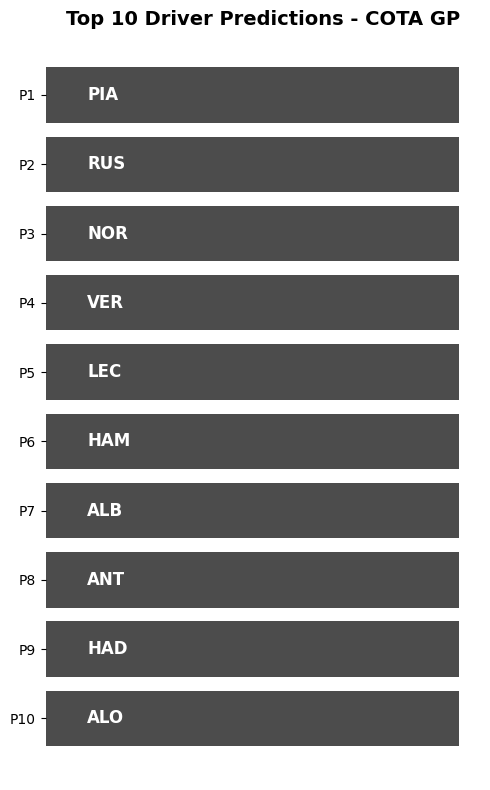

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 8))

# Show drivers as bars stacked from P1 downwards
plt.barh(top_10_output['final_predicted_pos'], 
         [1]*len(top_10_output),  # all bars same length (just placeholders)
         color='black', alpha=0.7)

# Add driver abbreviations next to each "position"
for i, row in top_10_output.iterrows():
    plt.text(0.1, row['final_predicted_pos'], row['Abbreviation'],
             va='center', ha='left', fontsize=12, fontweight='bold', color='white')

plt.yticks(top_10_output['final_predicted_pos'], 
           [f"P{pos}" for pos in top_10_output['final_predicted_pos']])

plt.gca().invert_yaxis()  # P1 at top
plt.gca().xaxis.set_visible(False)  # hide x-axis

plt.title("Top 10 Driver Predictions - COTA GP", fontsize=14, fontweight='bold')
plt.box(False)  # remove frame
plt.tight_layout()
plt.show()
